In [41]:
import mesma 
import rasterio
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from scipy.ndimage import binary_dilation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
c:\Users\attic\miniconda3\envs\hls_env\lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


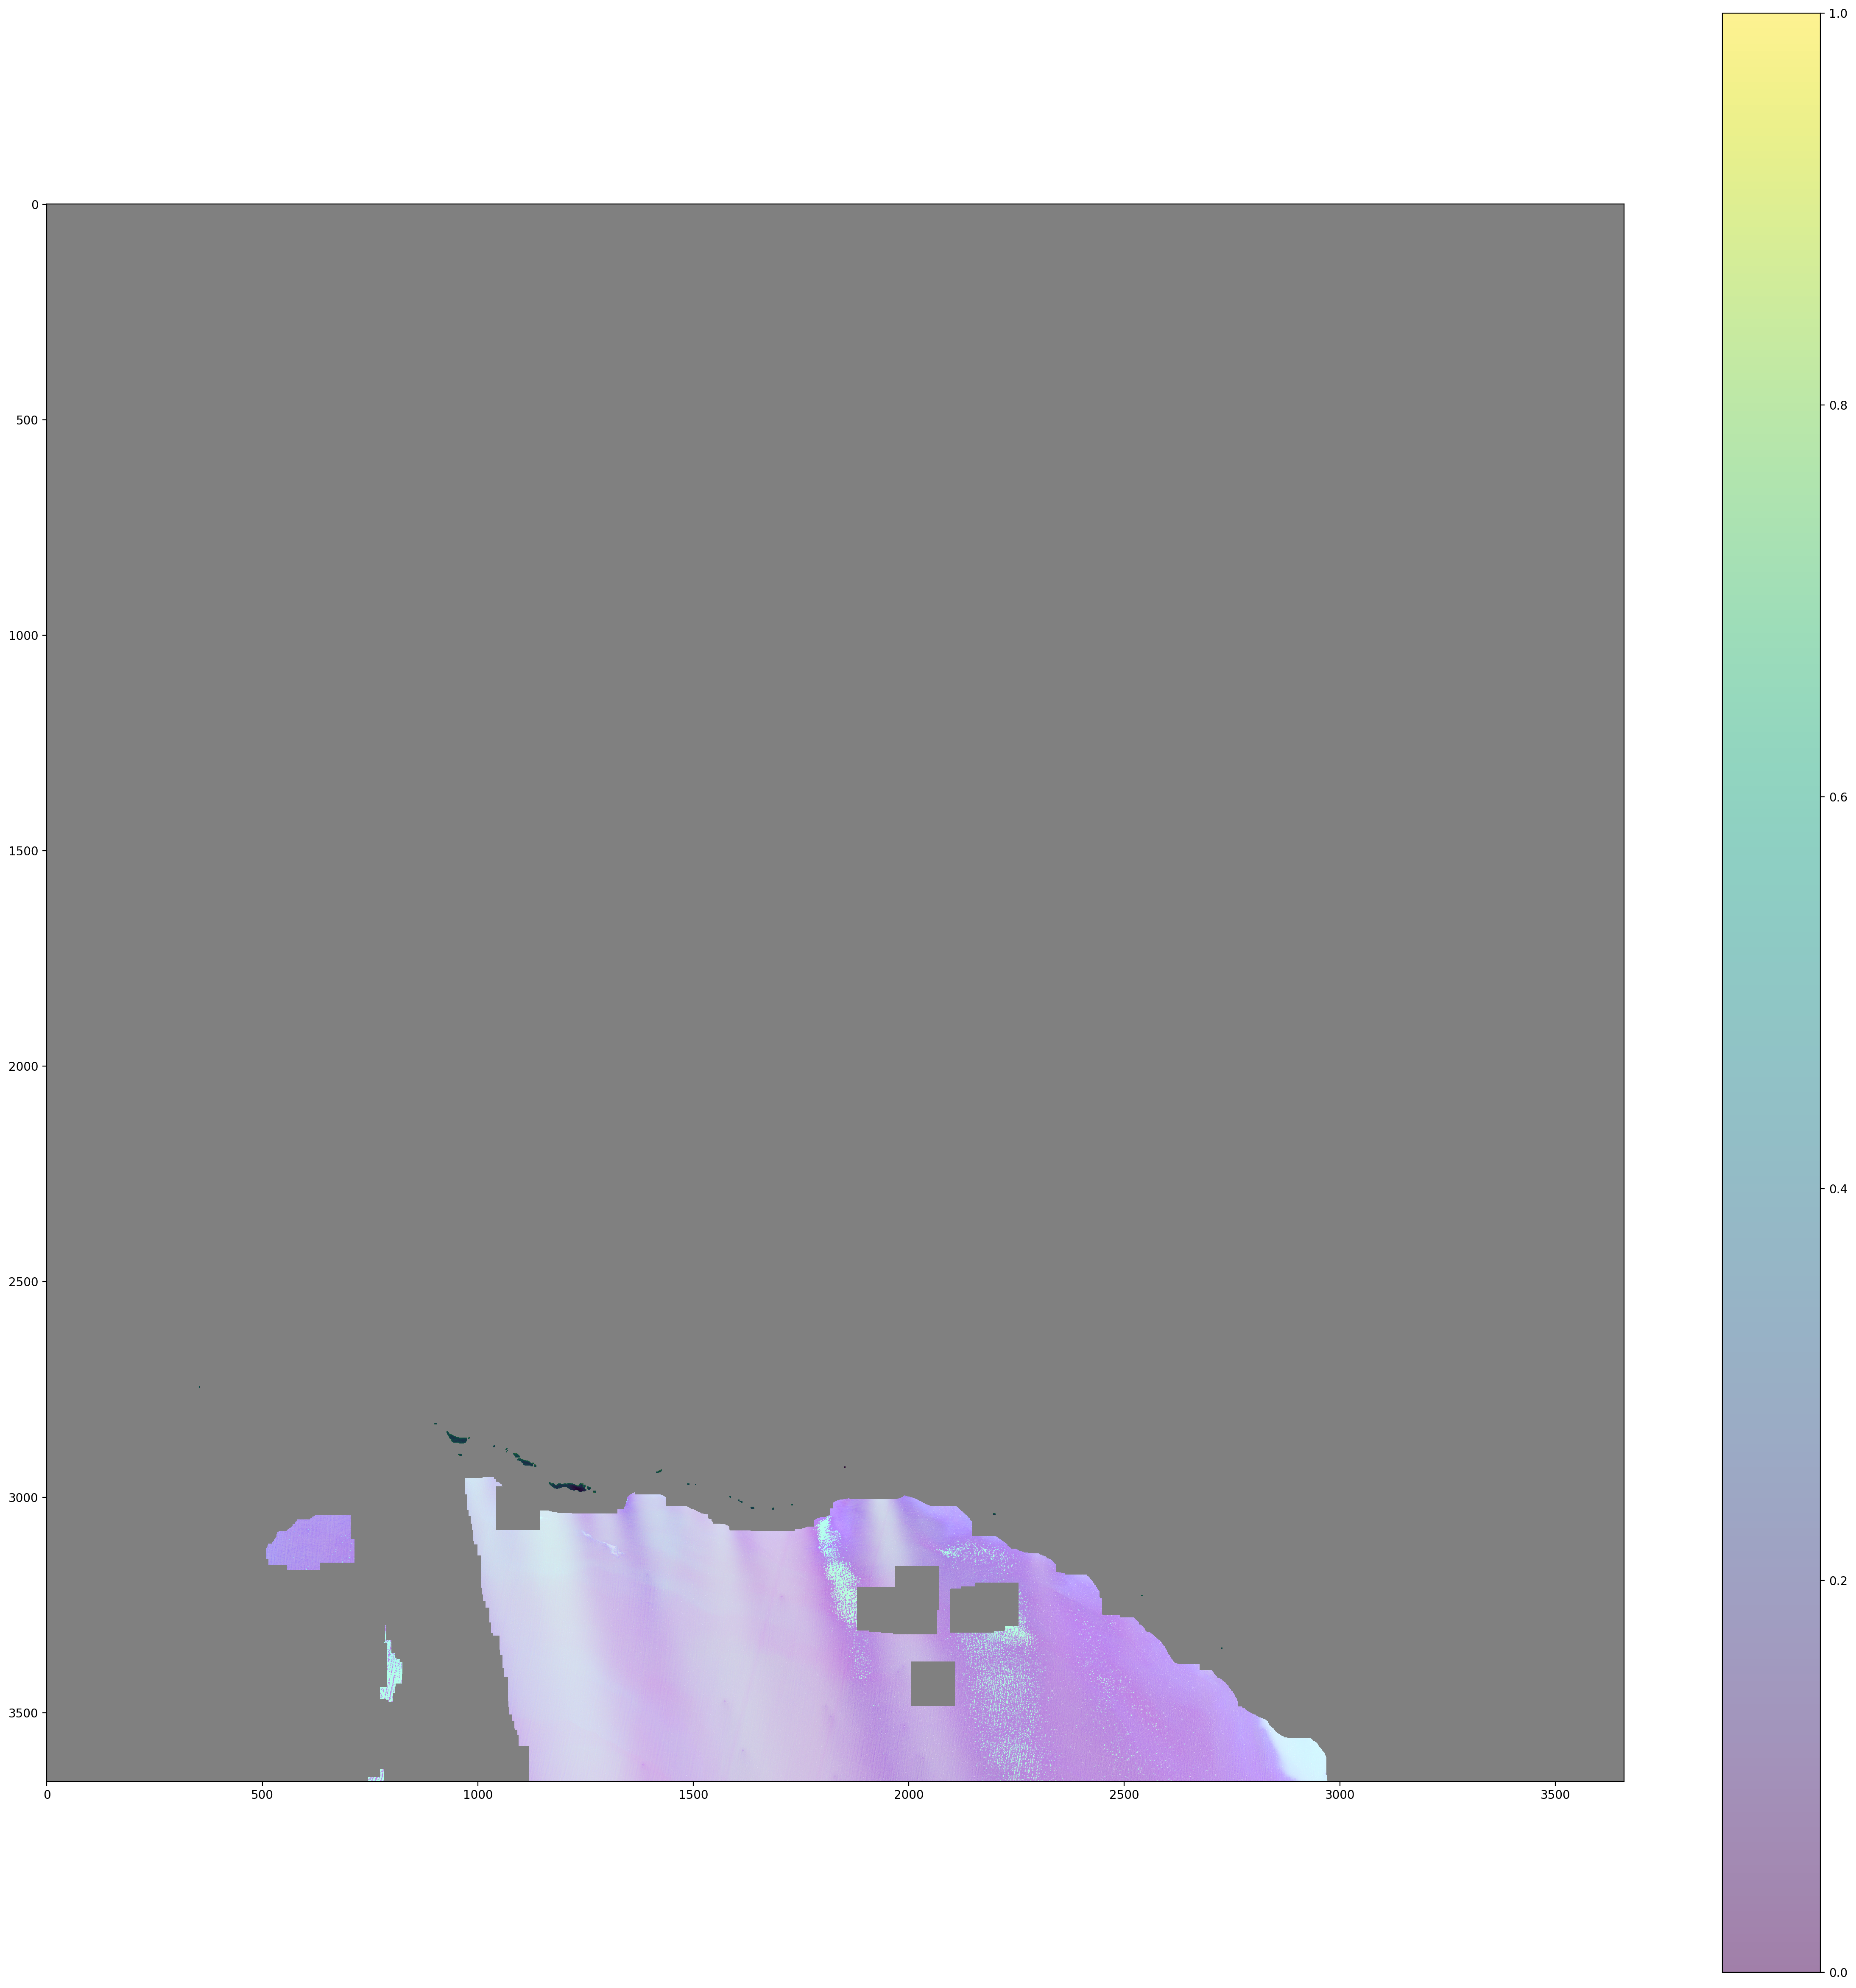

In [42]:
path = r'C:\Users\attic\HLS_Kelp\imagery\rf_training\HLS.L30.T11SKU.2018106T183324.v2.0_kelp_classified.tif'
ocean_dilation = np.ones((100,100)) #Struct for dilation (increase to enlarge non-ocean mask) larger --> takes longer
kelp_dilation = np.ones((4,4))
with rasterio.open(path) as imagery:
    classified_img = imagery.read(7)
    kelp_mask  = []
    ocean_mask = []
    ocean_dilated = np.where(classified_img == 1, False, True)
    ocean_dilated = binary_dilation(ocean_dilated, structure=ocean_dilation) #This takes ~25 seconds. Should look to optimize 
    kelp_dilated = np.where(classified_img == 0, True, False) #This is expanding hte kelp_mask so the TF is reversed
    kelp_dilated = binary_dilation(kelp_dilated,structure=kelp_dilation) #I may not want to do this. we'll see
    for i in range(4):
        band_data = imagery.read(i + 1)
        kmask = np.where(kelp_dilated == True, band_data, np.nan)
        omask = np.where(ocean_dilated == False, band_data, np.nan)
        kelp_mask.append(kmask)
        ocean_mask.append(omask)

    kelp_mask = np.array(kelp_mask)
    ocean_mask = np.array(ocean_mask)
    #print(ocean_mask)

rgb_nor = np.stack([ocean_mask[2]/60,ocean_mask[0]/60,ocean_mask[1]/60], axis=-1)
rgb_nor_cropped = rgb_nor
#print(kelp_mask)
rgb_nor_cropped = np.ma.masked_where(np.isnan(rgb_nor_cropped), rgb_nor_cropped)
image = kelp_mask[1]#,2500:3500,800:1800]
plt.figure(figsize=(30, 30), dpi=200)
plt.imshow(image, alpha=1)
plt.imshow(rgb_nor_cropped, alpha=.5)
plt.colorbar()
plt.show()

In [58]:
ocean_EM_stack = []
kelp_EM = [459, 556, 437, 1227]
print(kelp_mask.shape)
n_bands, height, width = kelp_mask.shape
print(n_bands)
ocean_EM_n = 0
ocean_data = ocean_mask.reshape(ocean_mask.shape[0], -1)
kelp_data = kelp_mask.reshape(kelp_mask.shape[0],-1)
print(ocean_data.shape)

nan_columns = np.isnan(ocean_data).any(axis=0)
# Remove columns with NaN values
filtered_ocean = ocean_data[:, ~nan_columns]
for i in range(30):
     index = random.randint(0,len(filtered_ocean[0])-1)
     ocean_EM_stack.append(filtered_ocean[:,index])
ocean_EM = np.stack(ocean_EM_stack, axis=1)
#print(ocean_EM_array)

average_val = np.nanmean(filtered_ocean, axis=1)
average_endmember = np.nanmean(ocean_EM, axis=1)
print(f"average EM Val: {average_endmember}")
print(f"average    Val: {average_val}")

(4, 3660, 3660)
4
(4, 13395600)
average EM Val: [31.73333333 49.33333333 33.66666667 37.66666667]
average    Val: [29.28570702 49.71599116 33.16466392 37.61065434]


In [87]:
frac1 = np.full((kelp_mask.shape[1], kelp_mask.shape[2], 30), np.nan)
frac2 = np.full((kelp_mask.shape[1], kelp_mask.shape[2], 30), np.nan)
rmse = np.full((kelp_mask.shape[1], kelp_mask.shape[2], 30), np.nan)
print(rmse.shape)

(3660, 3660, 30)


In [91]:
print("Running MESMA")
for k in range(30):
    B = np.column_stack((ocean_EM[:, k], kelp_EM))
    U, S, Vt = np.linalg.svd(B, full_matrices=False)
    IS = Vt.T / S
    em_inv = IS @ U.T
    F = em_inv @ kelp_data
    model = (F.T @ B.T).T
    resids = (kelp_data - model) / 10000
    rmse[:, :, k] = np.sqrt(np.mean(resids**2, axis=0)).reshape(height,width)
    frac1[:,:,k] = F[0, :].reshape(height,width)
    frac2[:, :, k] = F[1, :].reshape(height,width)
    print(f'Percent MESMA {round(100/30 * (k+1))}%')

Running MESMA
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 3%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 7%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 10%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 13%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 17%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 20%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 23%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 27%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 30%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 33%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 37%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 40%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 43%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 47%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 50%
(4, 13395600)
(4, 13395600)
(4, 13395600)
Percent MESMA 53%
(4, 13395600)
(4, 13395600)


TypeError: Invalid shape (3660, 3660, 30) for image data

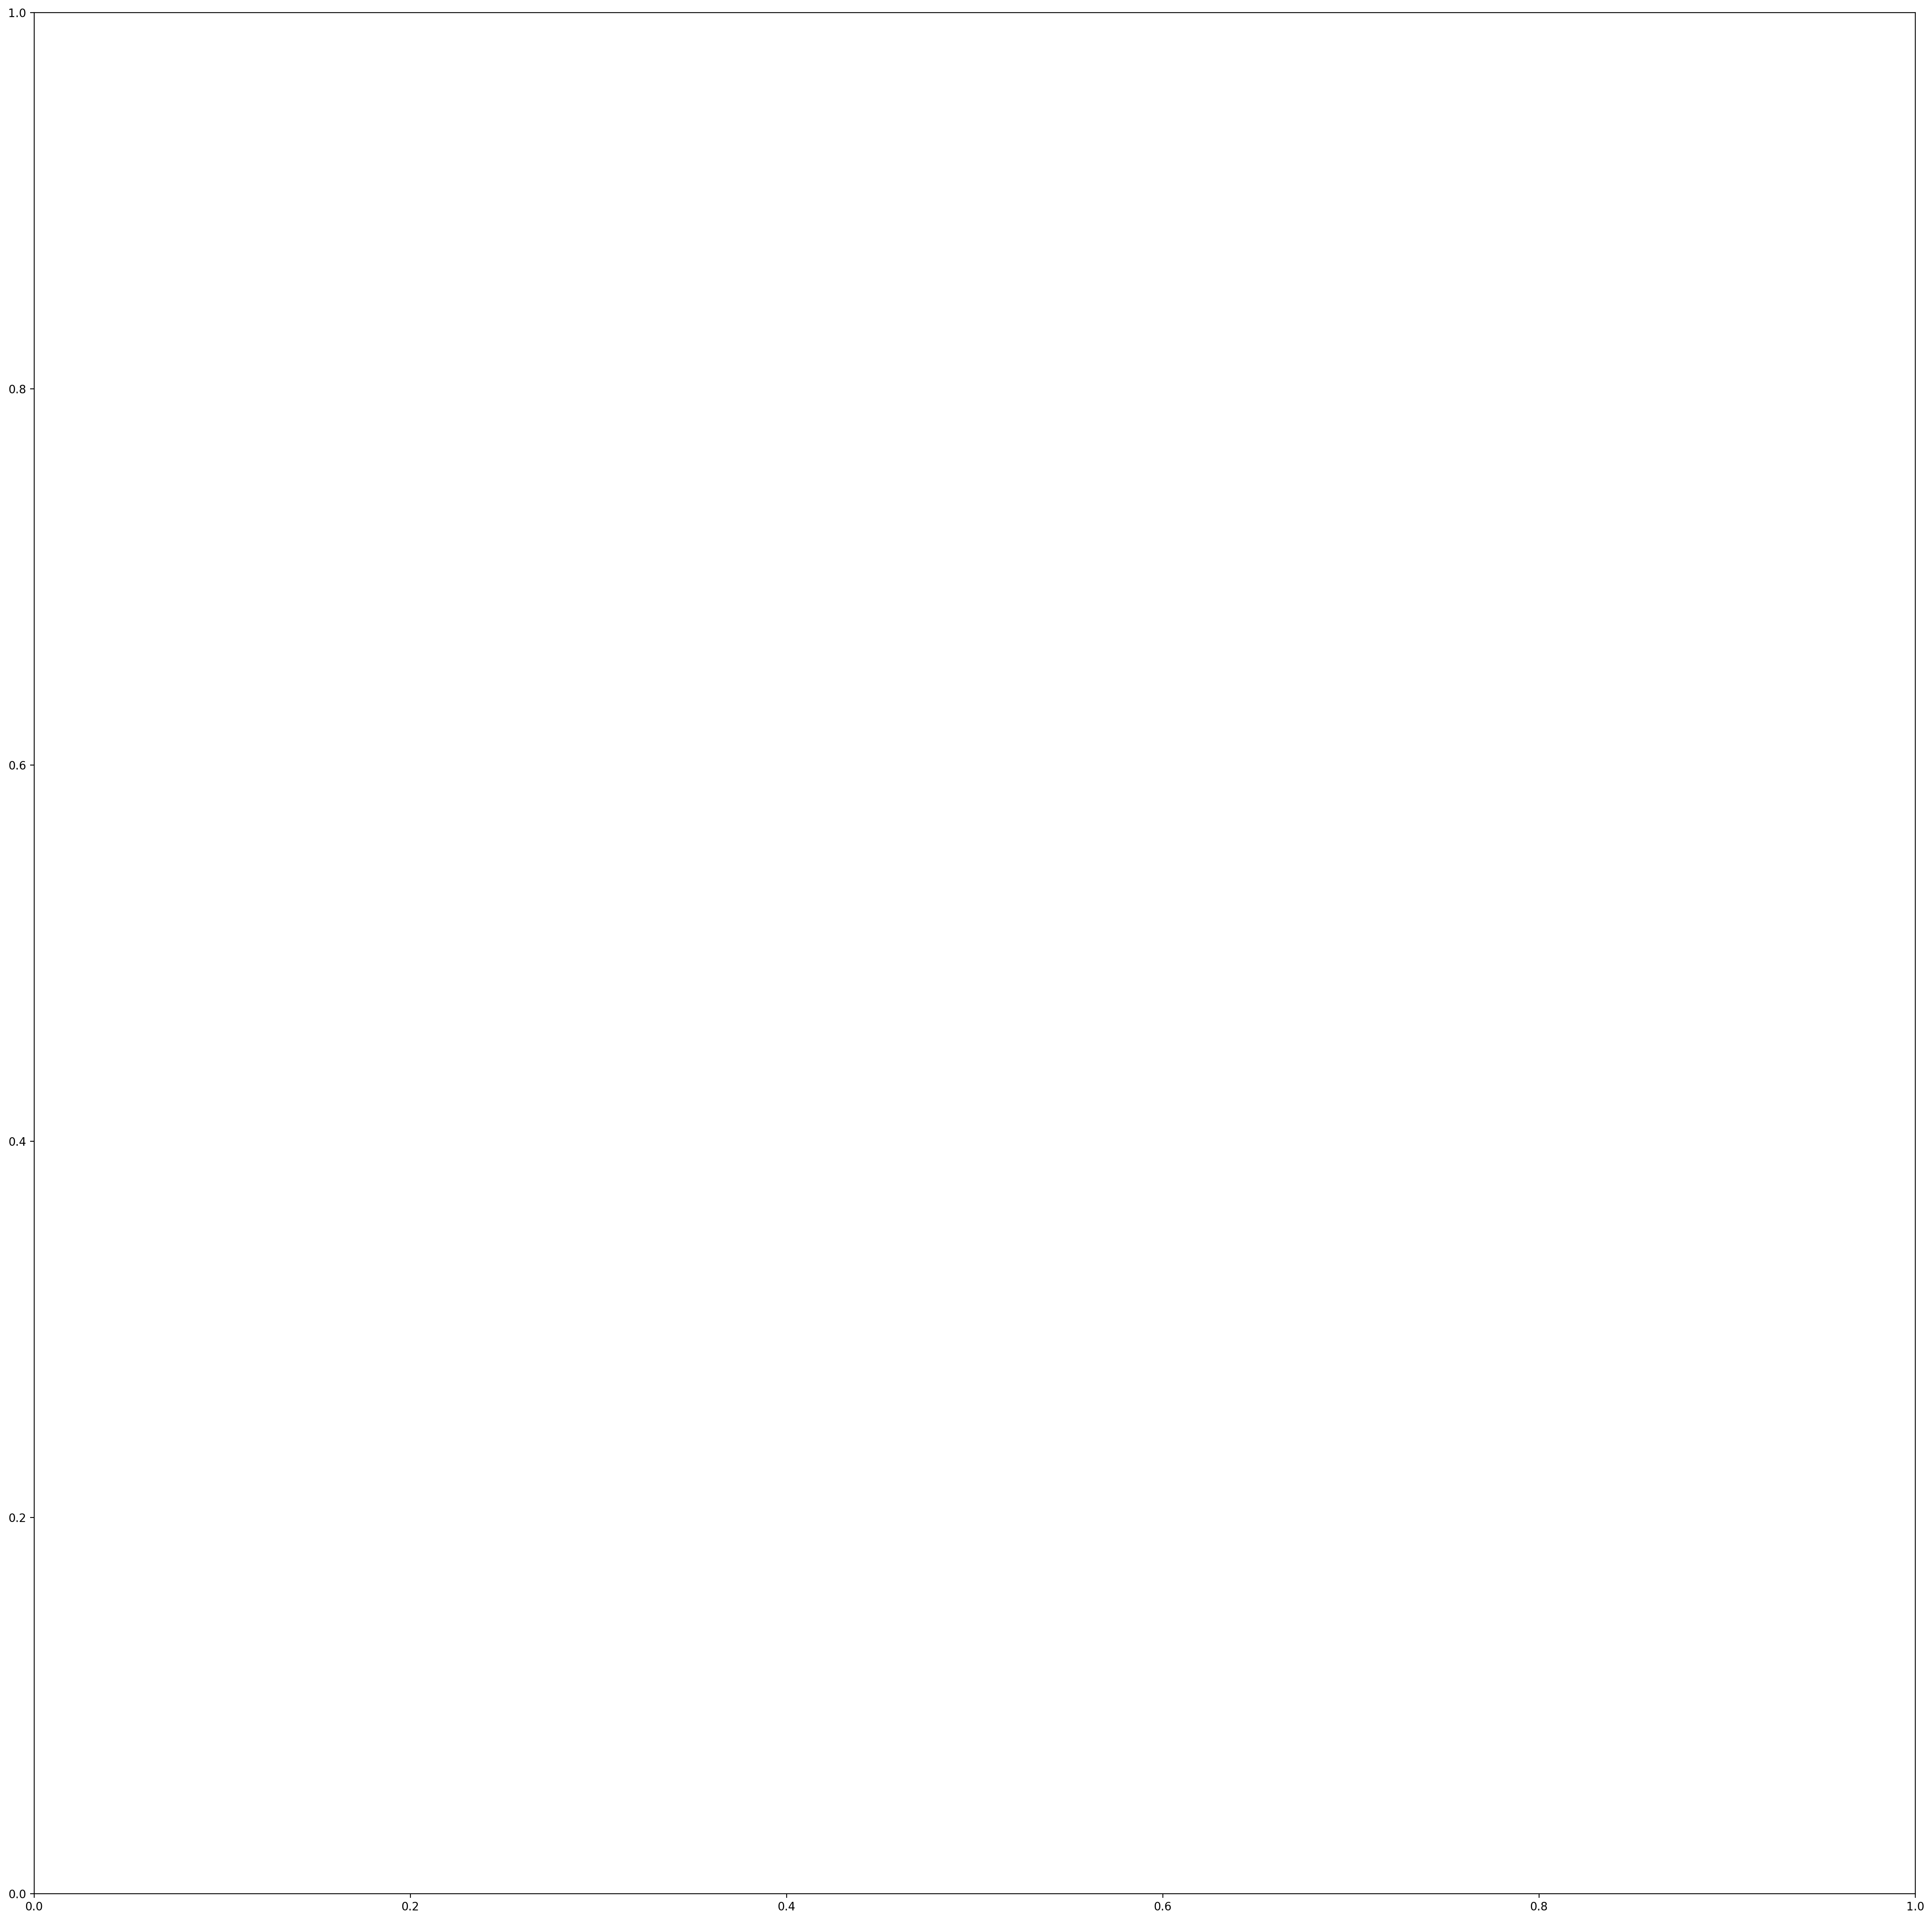

In [92]:
plt.figure(figsize=(30, 30), dpi=200)
plt.imshow(frac1, alpha=1)
plt.colorbar()
plt.show()